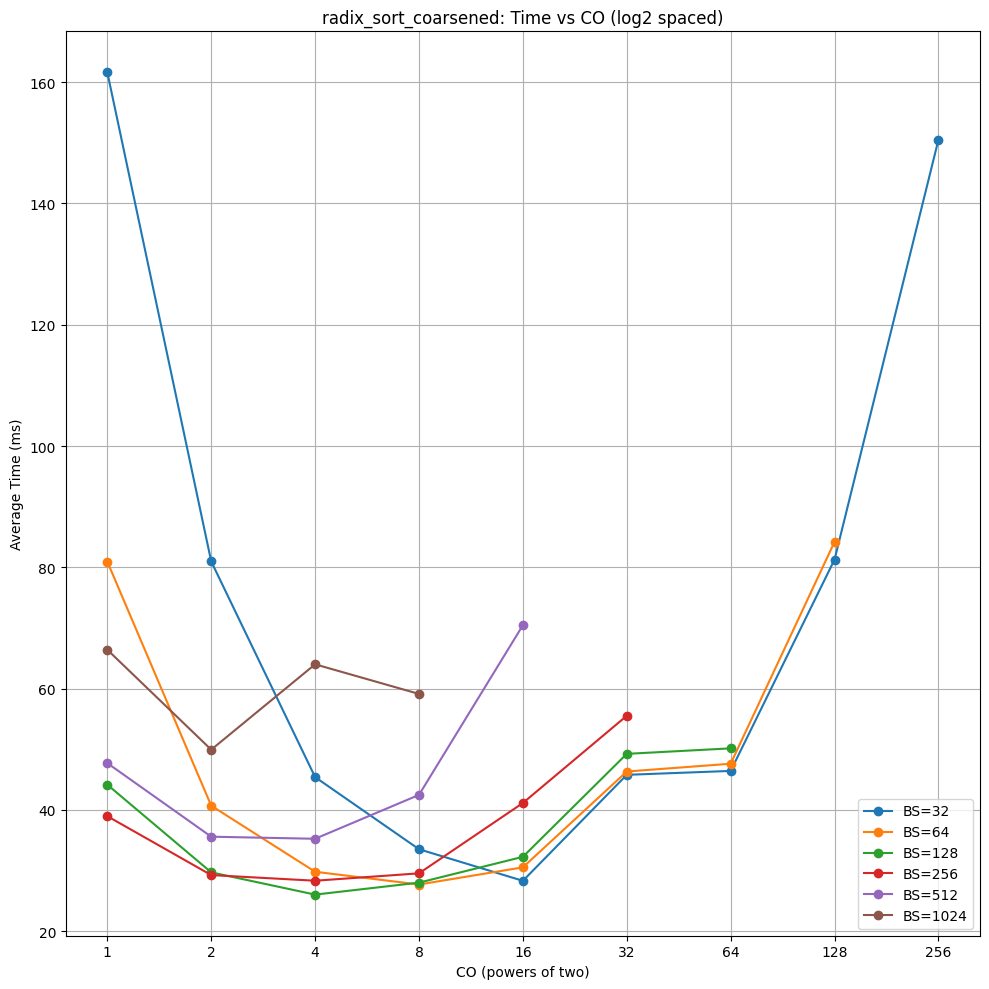

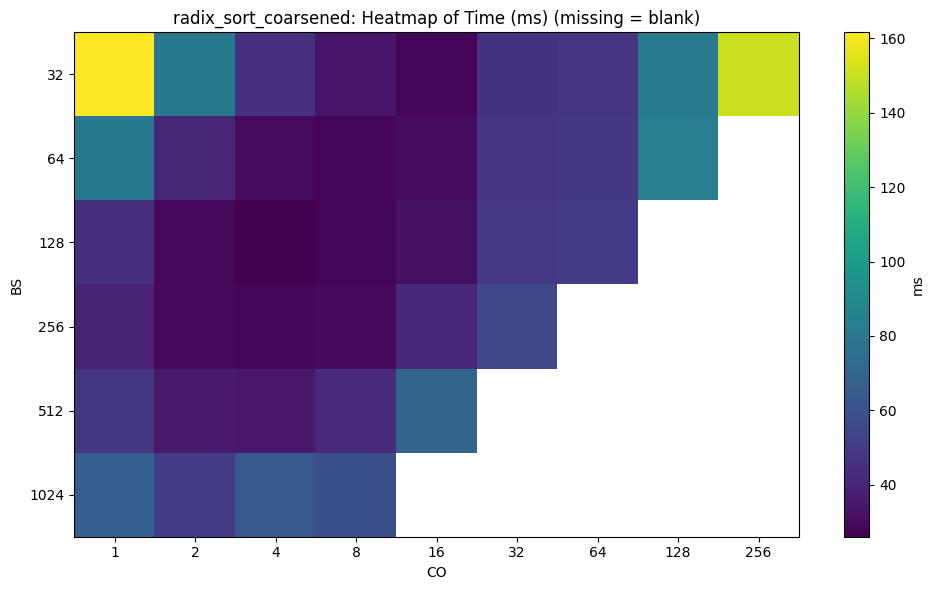

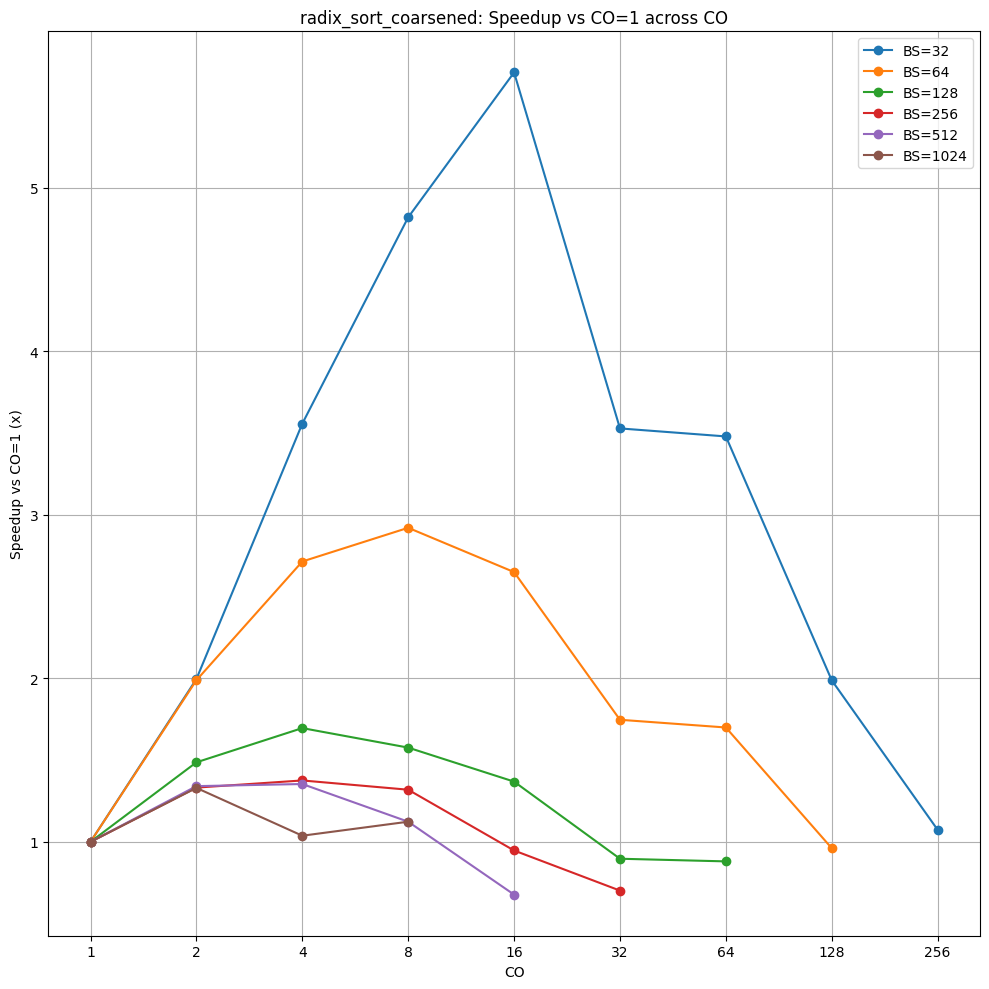

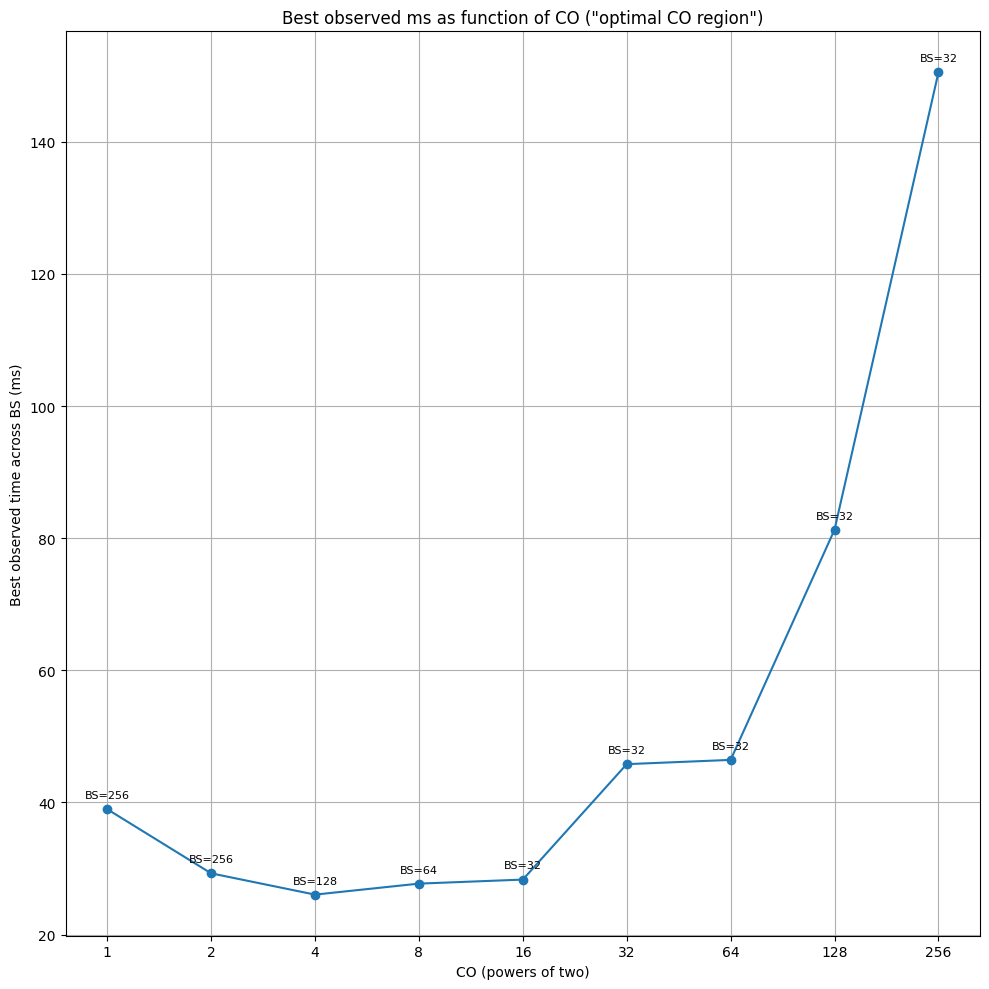

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from caas_jupyter_tools import display_dataframe_to_user

# Raw data (ms) exactly as provided; missing combos are NaN
rows = [
    (32,  {1:161.592827, 2:80.971284, 4:45.418840, 8:33.526192, 16:28.319040, 32:45.792926, 64:46.436958, 128:81.283205, 256:150.499213}),
    (64,  {1:80.936179, 2:40.702309, 4:29.813076, 8:27.708961, 16:30.541148, 32:46.336899, 64:47.622131, 128:84.207284}),
    (128, {1:44.165486, 2:29.711831, 4:26.044274, 8:28.015491, 16:32.274519, 32:49.250863, 64:50.157660}),
    (256, {1:38.975468, 2:29.266344, 4:28.333358, 8:29.551520, 16:41.149399, 32:55.531062}),
    (512, {1:47.721560, 2:35.593579, 4:35.249997, 8:42.485775, 16:70.458574}),
    (1024,{1:66.418224, 2:49.938743, 4:64.013246, 8:59.129605}),
]

COs = [1,2,4,8,16,32,64,128,256]
df = pd.DataFrame(index=[r[0] for r in rows], columns=COs, dtype=float)
for bs, m in rows:
    for co, t in m.items():
        df.loc[bs, co] = t

df.index.name = "BS"
df.columns.name = "CO"
# display_dataframe_to_user("Benchmark (ms): BS rows x CO columns", df)

# Summary stats
summary = pd.DataFrame({
    "best_time_ms": df.min(axis=1),
    "best_CO": df.idxmin(axis=1),
    "worst_time_ms": df.max(axis=1),
    "worst_CO": df.idxmax(axis=1),
})
summary["speedup_best_vs_CO1"] = df[1] / summary["best_time_ms"]
# display_dataframe_to_user("Per-BS best/worst and speedup vs CO=1", summary)

# 1) Line chart with log2(CO) x-axis (keeps spacing meaningful for powers of two)
plt.figure(figsize=(10,10))
for bs in df.index:
    x = np.log2(df.columns.values.astype(float))
    y = df.loc[bs].values.astype(float)
    plt.plot(x, y, marker='o', label=f'BS={bs}')
plt.xticks(np.log2(np.array(COs, dtype=float)), [str(c) for c in COs])
plt.xlabel("CO (powers of two)")
plt.ylabel("Average Time (ms)")
plt.title("radix_sort_coarsened: Time vs CO (log2 spaced)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('1.png', dpi=150)
plt.show()

# 2) Heatmap (matrix view) with NaNs left blank via masking
plt.figure(figsize=(10,6))
mat = df.values.astype(float)
masked = np.ma.masked_invalid(mat)
plt.imshow(masked, aspect='auto', interpolation='nearest')
plt.yticks(np.arange(len(df.index)), [str(i) for i in df.index])
plt.xticks(np.arange(len(df.columns)), [str(c) for c in df.columns])
plt.xlabel("CO")
plt.ylabel("BS")
plt.title("radix_sort_coarsened: Heatmap of Time (ms) (missing = blank)")
plt.colorbar(label="ms")
plt.tight_layout()
plt.savefig('2.png', dpi=150)
plt.show()

# 3) Speedup vs CO=1 per BS (missing stays NaN)
speedup = df.div(df[1], axis=0)  # time / time_at_CO1
# Convert to "speedup" (CO1 / time), so higher is better
speedup2 = df[1].to_frame().values / df.values
speedup_df = pd.DataFrame(speedup2, index=df.index, columns=df.columns)
# display_dataframe_to_user("Speedup relative to CO=1 (higher is better)", speedup_df)

plt.figure(figsize=(10,10))
for bs in speedup_df.index:
    x = np.log2(speedup_df.columns.values.astype(float))
    y = speedup_df.loc[bs].values.astype(float)
    plt.plot(x, y, marker='o', label=f'BS={bs}')
plt.xticks(np.log2(np.array(COs, dtype=float)), [str(c) for c in COs])
plt.xlabel("CO")
plt.ylabel("Speedup vs CO=1 (x)")
plt.title("radix_sort_coarsened: Speedup vs CO=1 across CO")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('3.png', dpi=150)
plt.show()

# 4) Best observed ms as function of CO (min across BS; missing ignored)
best_ms_by_co = df.min(axis=0, skipna=True)
best_bs_by_co = df.idxmin(axis=0, skipna=True)

plt.figure(figsize=(10,10))
x = np.log2(best_ms_by_co.index.values.astype(float))
y = best_ms_by_co.values.astype(float)
plt.plot(x, y, marker='o')
plt.xticks(np.log2(np.array(COs, dtype=float)), [str(c) for c in COs])
plt.xlabel("CO (powers of two)")
plt.ylabel("Best observed time across BS (ms)")
plt.title('Best observed ms as function of CO ("optimal CO region")')
plt.grid(True)

for xi, yi, co in zip(x, y, best_ms_by_co.index.values):
    if np.isfinite(yi):
        bs = int(best_bs_by_co.loc[co])
        plt.annotate(f"BS={bs}", (xi, yi),
                     textcoords="offset points", xytext=(0, 8),
                     ha='center', fontsize=8)
plt.tight_layout()
plt.savefig('4.png', dpi=150)
plt.show()

